In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle
import pandas as pd

2025-10-09 16:30:44.129043: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760027444.305356      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760027444.366286      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# MNIST Dataset
(x_train_mnist, y_train_mnist), (x_test_mnist, y_test_mnist) = keras.datasets.mnist.load_data()
x_train_mnist = x_train_mnist.astype('float32') / 255.0
x_test_mnist = x_test_mnist.astype('float32') / 255.0

# CIFAR-10 Dataset
(x_train_cifar, y_train_cifar), (x_test_cifar, y_test_cifar) = keras.datasets.cifar10.load_data()
x_train_cifar = x_train_cifar.astype('float32') / 255.0
x_test_cifar = x_test_cifar.astype('float32') / 255.0
y_train_cifar = y_train_cifar.flatten()
y_test_cifar = y_test_cifar.flatten()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [3]:
def create_rnn_model_mnist():
    model = models.Sequential([
        layers.LSTM(128, input_shape=(28, 28)),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')
    ])
    return model

In [4]:
def create_rnn_model_cifar():
    model = models.Sequential([
        layers.LSTM(128, return_sequences=True, input_shape=(32, 96)),
        layers.LSTM(128),
        layers.Dropout(0.4),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')
    ])
    return model

In [5]:
split_ratios = [0.6, 0.7, 0.8]
results_mnist = []
results_cifar = []
histories_mnist = {}
histories_cifar = {}
models_mnist = {}
models_cifar = {}

In [6]:
print("="*80)
print("TRAINING RNN MODELS WITH DIFFERENT TRAIN-TEST SPLITS")
print("="*80)

for split in split_ratios:
    print(f"\n{'='*80}")
    print(f"Training with {int(split*100)}% train - {int((1-split)*100)}% validation split")
    print(f"{'='*80}")

    # MNIST RNN Training 
    train_size_mnist = int(len(x_train_mnist) * split)
    x_tr_mnist, y_tr_mnist = x_train_mnist[:train_size_mnist], y_train_mnist[:train_size_mnist]
    x_val_mnist, y_val_mnist = x_train_mnist[train_size_mnist:], y_train_mnist[train_size_mnist:]
    
    y_tr_mnist_cat = keras.utils.to_categorical(y_tr_mnist, 10)
    y_val_mnist_cat = keras.utils.to_categorical(y_val_mnist, 10)
    y_test_mnist_cat = keras.utils.to_categorical(y_test_mnist, 10)

    print(f"\nMNIST - Training samples: {len(x_tr_mnist)}, Validation samples: {len(x_val_mnist)}")
    model_mnist = create_rnn_model_mnist()
    model_mnist.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    history_mnist = model_mnist.fit(x_tr_mnist, y_tr_mnist_cat, epochs=15, batch_size=128,
                                    validation_data=(x_val_mnist, y_val_mnist_cat), verbose=0)
    test_loss_mnist, test_acc_mnist = model_mnist.evaluate(x_test_mnist, y_test_mnist_cat, verbose=0)
    
    results_mnist.append({
        'split': f"{int(split*100)}-{int((1-split)*100)}",
        'train_acc': history_mnist.history['accuracy'][-1],
        'val_acc': history_mnist.history['val_accuracy'][-1],
        'test_acc': test_acc_mnist
    })
    histories_mnist[split] = history_mnist
    models_mnist[split] = model_mnist
    print(f"MNIST Test Accuracy: {test_acc_mnist:.4f}")

    # CIFAR RNN Training
    # Reshape 
    x_train_cifar_rnn = x_train_cifar.reshape(-1, 32, 32 * 3)
    x_test_cifar_rnn = x_test_cifar.reshape(-1, 32, 32 * 3)

    train_size_cifar = int(len(x_train_cifar_rnn) * split)
    x_tr_cifar, y_tr_cifar = x_train_cifar_rnn[:train_size_cifar], y_train_cifar[:train_size_cifar]
    x_val_cifar, y_val_cifar = x_train_cifar_rnn[train_size_cifar:], y_train_cifar[train_size_cifar:]

    y_tr_cifar_cat = keras.utils.to_categorical(y_tr_cifar, 10)
    y_val_cifar_cat = keras.utils.to_categorical(y_val_cifar, 10)
    y_test_cifar_cat = keras.utils.to_categorical(y_test_cifar, 10)
    
    print(f"\nCIFAR-10 - Training samples: {len(x_tr_cifar)}, Validation samples: {len(x_val_cifar)}")
    model_cifar = create_rnn_model_cifar()
    model_cifar.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    history_cifar = model_cifar.fit(x_tr_cifar, y_tr_cifar_cat, epochs=50, batch_size=128,
                                    validation_data=(x_val_cifar, y_val_cifar_cat), verbose=0)
    test_loss_cifar, test_acc_cifar = model_cifar.evaluate(x_test_cifar_rnn, y_test_cifar_cat, verbose=0)
    
    results_cifar.append({
        'split': f"{int(split*100)}-{int((1-split)*100)}",
        'train_acc': history_cifar.history['accuracy'][-1],
        'val_acc': history_cifar.history['val_accuracy'][-1],
        'test_acc': test_acc_cifar
    })
    histories_cifar[split] = history_cifar
    models_cifar[split] = model_cifar
    print(f"CIFAR-10 Test Accuracy: {test_acc_cifar:.4f}")

df_mnist = pd.DataFrame(results_mnist)
df_cifar = pd.DataFrame(results_cifar)

TRAINING RNN MODELS WITH DIFFERENT TRAIN-TEST SPLITS

Training with 60% train - 40% validation split

MNIST - Training samples: 36000, Validation samples: 24000


I0000 00:00:1760027528.160723      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
I0000 00:00:1760027532.493006      97 cuda_dnn.cc:529] Loaded cuDNN version 90300


MNIST Test Accuracy: 0.9795

CIFAR-10 - Training samples: 30000, Validation samples: 20000
CIFAR-10 Test Accuracy: 0.5686

Training with 70% train - 30% validation split

MNIST - Training samples: 42000, Validation samples: 18000
MNIST Test Accuracy: 0.9850

CIFAR-10 - Training samples: 35000, Validation samples: 15000
CIFAR-10 Test Accuracy: 0.5784

Training with 80% train - 19% validation split

MNIST - Training samples: 48000, Validation samples: 12000
MNIST Test Accuracy: 0.9863

CIFAR-10 - Training samples: 40000, Validation samples: 10000
CIFAR-10 Test Accuracy: 0.5950



RNN MNIST RESULTS - DIFFERENT TRAIN-TEST SPLITS
split  train_acc  val_acc  test_acc
60-40   0.987778 0.979083    0.9795
70-30   0.988500 0.983444    0.9850
80-19   0.989396 0.984250    0.9863

RNN CIFAR-10 RESULTS - DIFFERENT TRAIN-TEST SPLITS
split  train_acc  val_acc  test_acc
60-40   0.858900  0.56085    0.5686
70-30   0.871629  0.58920    0.5784
80-19   0.872725  0.60380    0.5950


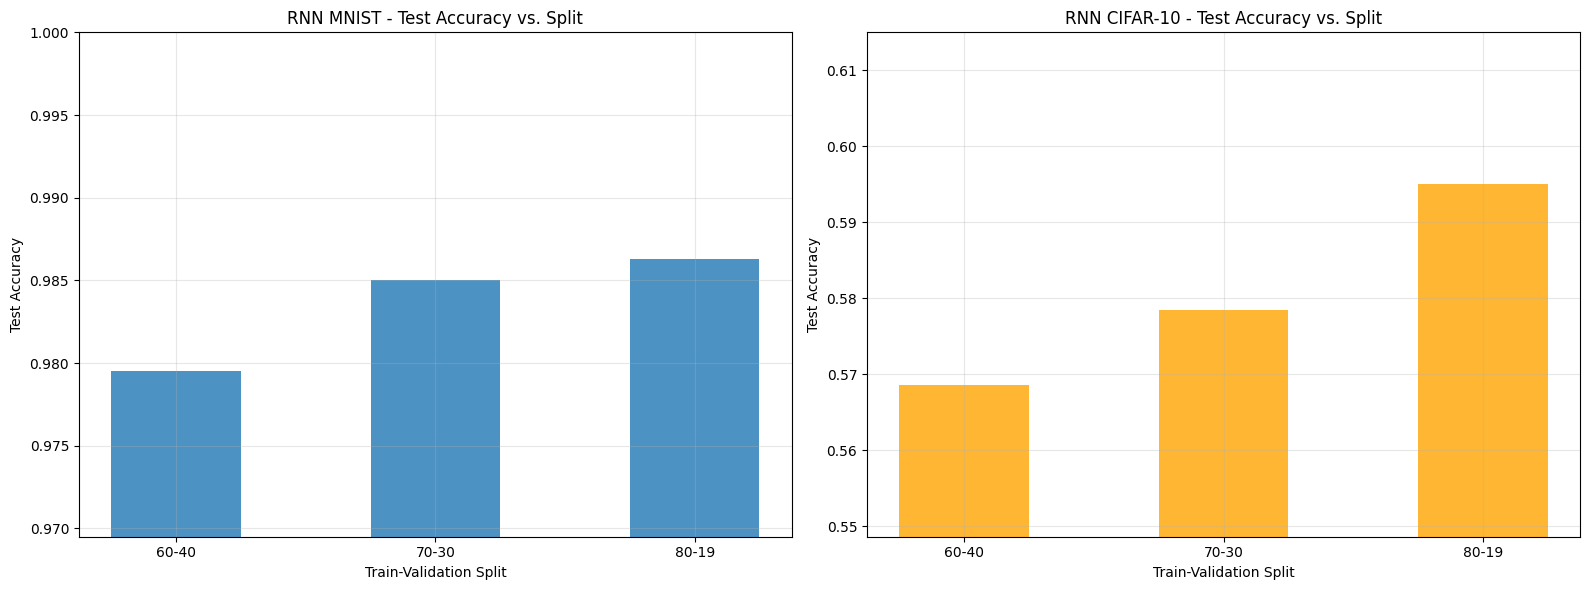

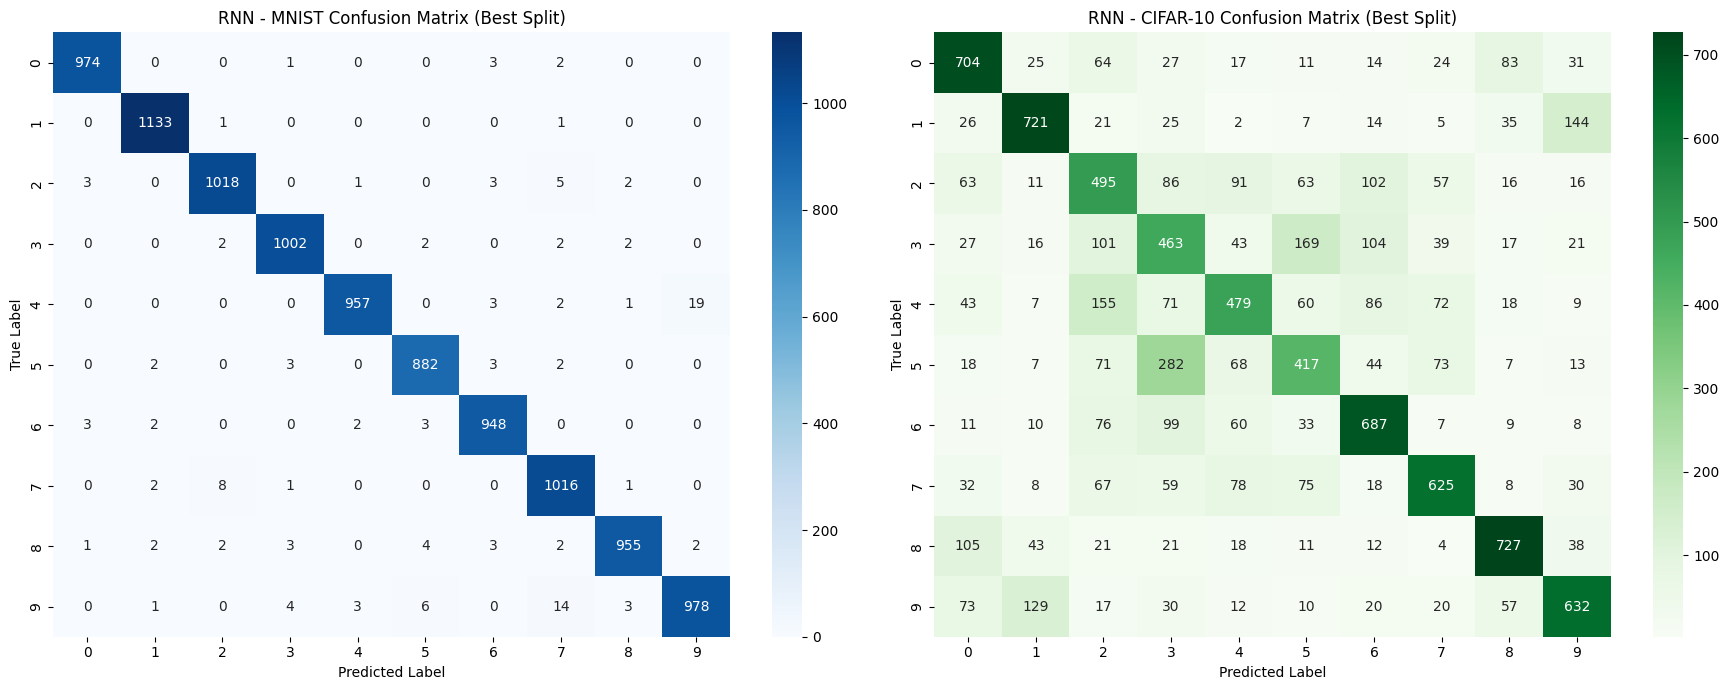

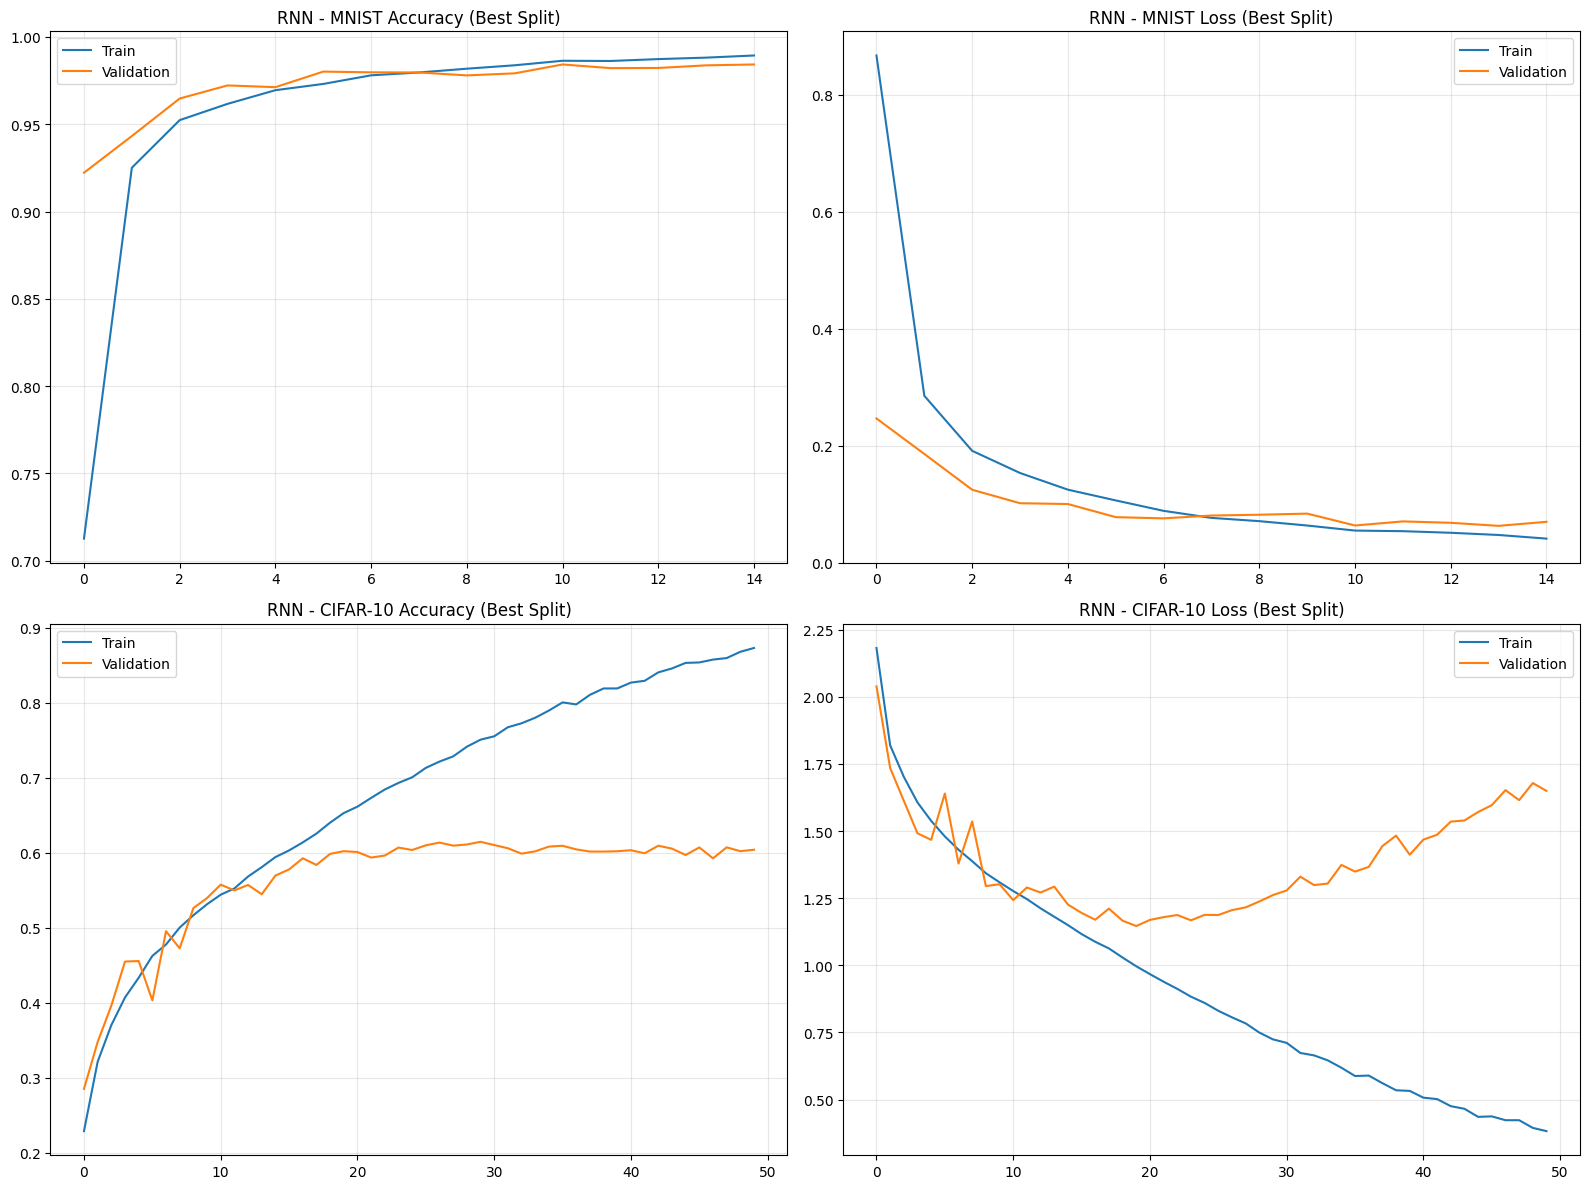

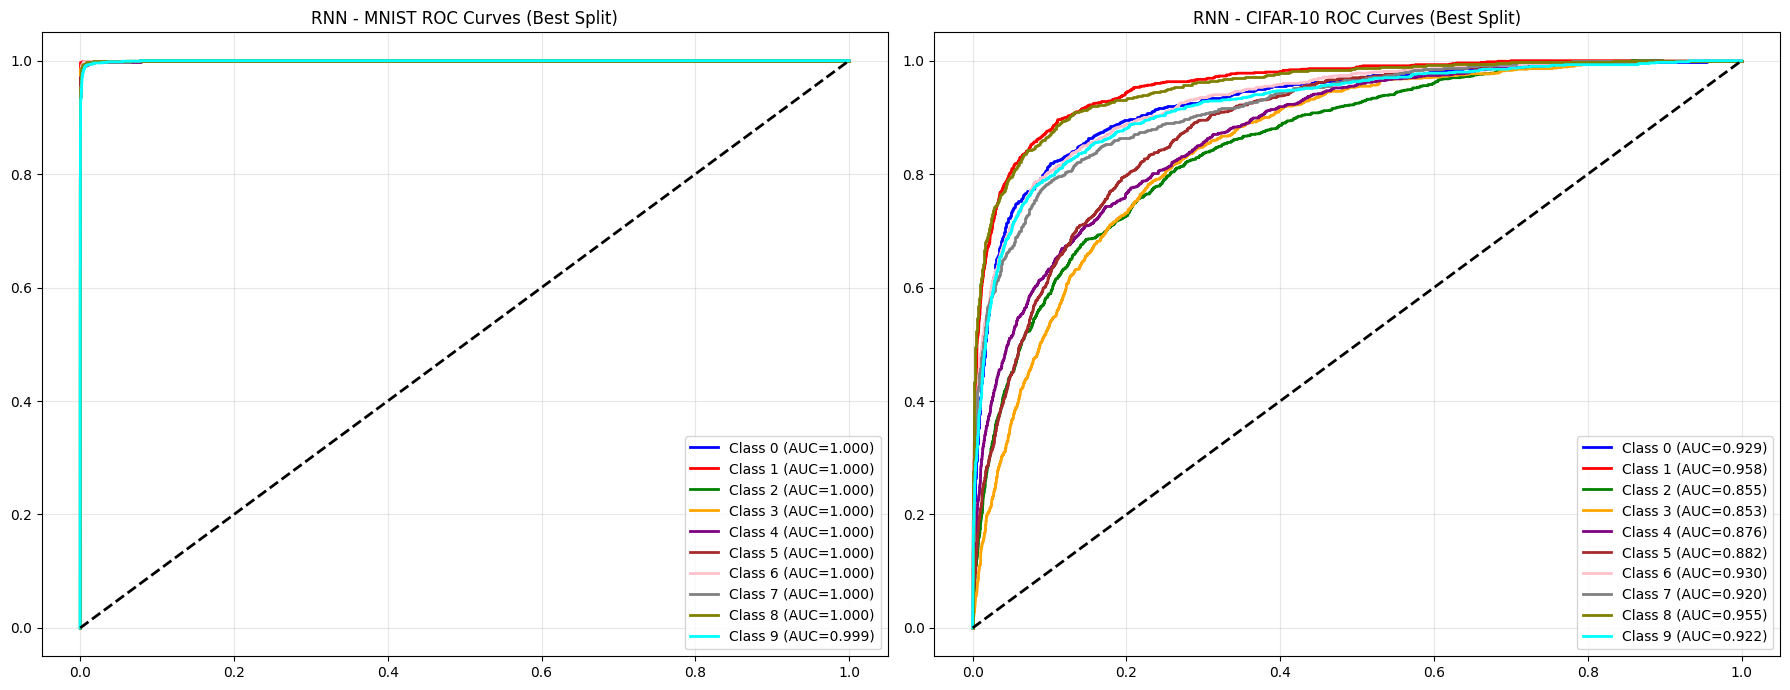

In [7]:
print("\n" + "="*80)
print("RNN MNIST RESULTS - DIFFERENT TRAIN-TEST SPLITS")
print("="*80)
print(df_mnist.to_string(index=False))

print("\n" + "="*80)
print("RNN CIFAR-10 RESULTS - DIFFERENT TRAIN-TEST SPLITS")
print("="*80)
print(df_cifar.to_string(index=False))

# Accuracy Comparison Bar Charts
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
splits_labels = [f"{int(s*100)}-{int((1-s)*100)}" for s in split_ratios]
mnist_test_accs = [r['test_acc'] for r in results_mnist]
cifar_test_accs = [r['test_acc'] for r in results_cifar]
x_pos = np.arange(len(splits_labels))

axes[0].bar(x_pos, mnist_test_accs, width=0.5, alpha=0.8)
axes[0].set_xlabel('Train-Validation Split')
axes[0].set_ylabel('Test Accuracy')
axes[0].set_title('RNN MNIST - Test Accuracy vs. Split')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(splits_labels)
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim([min(mnist_test_accs)-0.01, 1.0])

axes[1].bar(x_pos, cifar_test_accs, width=0.5, alpha=0.8, color='orange')
axes[1].set_xlabel('Train-Validation Split')
axes[1].set_ylabel('Test Accuracy')
axes[1].set_title('RNN CIFAR-10 - Test Accuracy vs. Split')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(splits_labels)
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim([min(cifar_test_accs)-0.02, max(cifar_test_accs)+0.02])

plt.tight_layout()
plt.show()

# Find and visualize the best models
best_split_mnist = split_ratios[np.argmax([r['test_acc'] for r in results_mnist])]
best_split_cifar = split_ratios[np.argmax([r['test_acc'] for r in results_cifar])]

best_model_mnist = models_mnist[best_split_mnist]
best_model_cifar = models_cifar[best_split_cifar]
best_history_mnist = histories_mnist[best_split_mnist]
best_history_cifar = histories_cifar[best_split_cifar]

# Confusion Matrices for Best Models
y_pred_mnist = best_model_mnist.predict(x_test_mnist.reshape(-1, 28, 28), verbose=0)
y_pred_mnist_classes = np.argmax(y_pred_mnist, axis=1)

y_pred_cifar = best_model_cifar.predict(x_test_cifar.reshape(-1, 32, 96), verbose=0)
y_pred_cifar_classes = np.argmax(y_pred_cifar, axis=1)

cm_mnist = confusion_matrix(y_test_mnist, y_pred_mnist_classes)
cm_cifar = confusion_matrix(y_test_cifar, y_pred_cifar_classes)

fig, axes = plt.subplots(1, 2, figsize=(18, 7))
sns.heatmap(cm_mnist, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title(f'RNN - MNIST Confusion Matrix (Best Split)')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

sns.heatmap(cm_cifar, annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title(f'RNN - CIFAR-10 Confusion Matrix (Best Split)')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

# Training & Loss Curves for Best Models
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes[0, 0].plot(best_history_mnist.history['accuracy'], label='Train')
axes[0, 0].plot(best_history_mnist.history['val_accuracy'], label='Validation')
axes[0, 0].set_title(f'RNN - MNIST Accuracy (Best Split)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
axes[0, 1].plot(best_history_mnist.history['loss'], label='Train')
axes[0, 1].plot(best_history_mnist.history['val_loss'], label='Validation')
axes[0, 1].set_title(f'RNN - MNIST Loss (Best Split)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)
axes[1, 0].plot(best_history_cifar.history['accuracy'], label='Train')
axes[1, 0].plot(best_history_cifar.history['val_accuracy'], label='Validation')
axes[1, 0].set_title(f'RNN - CIFAR-10 Accuracy (Best Split)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)
axes[1, 1].plot(best_history_cifar.history['loss'], label='Train')
axes[1, 1].plot(best_history_cifar.history['val_loss'], label='Validation')
axes[1, 1].set_title(f'RNN - CIFAR-10 Loss (Best Split)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ROC/AUC Curves for Best Models
y_test_mnist_bin = label_binarize(y_test_mnist, classes=range(10))
y_test_cifar_bin = label_binarize(y_test_cifar, classes=range(10))
n_classes = 10
fpr_mnist, tpr_mnist, roc_auc_mnist = {}, {}, {}
fpr_cifar, tpr_cifar, roc_auc_cifar = {}, {}, {}

for i in range(n_classes):
    fpr_mnist[i], tpr_mnist[i], _ = roc_curve(y_test_mnist_bin[:, i], y_pred_mnist[:, i])
    roc_auc_mnist[i] = auc(fpr_mnist[i], tpr_mnist[i])
    fpr_cifar[i], tpr_cifar[i], _ = roc_curve(y_test_cifar_bin[:, i], y_pred_cifar[:, i])
    roc_auc_cifar[i] = auc(fpr_cifar[i], tpr_cifar[i])

fig, axes = plt.subplots(1, 2, figsize=(18, 7))
colors = cycle(['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan'])
for i, color in zip(range(n_classes), colors):
    axes[0].plot(fpr_mnist[i], tpr_mnist[i], color=color, lw=2, label=f'Class {i} (AUC={roc_auc_mnist[i]:.3f})')
axes[0].plot([0, 1], [0, 1], 'k--', lw=2)
axes[0].set_title(f'RNN - MNIST ROC Curves (Best Split)')
axes[0].legend(loc="lower right")
axes[0].grid(True, alpha=0.3)

colors = cycle(['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan'])
for i, color in zip(range(n_classes), colors):
    axes[1].plot(fpr_cifar[i], tpr_cifar[i], color=color, lw=2, label=f'Class {i} (AUC={roc_auc_cifar[i]:.3f})')
axes[1].plot([0, 1], [0, 1], 'k--', lw=2)
axes[1].set_title(f'RNN - CIFAR-10 ROC Curves (Best Split)')
axes[1].legend(loc="lower right")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()